In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision.models import VGG16_Weights, vgg16

In [2]:
class CIFAR10Backdoor(Dataset):
    def __init__(self, root, train=True, pre_transform=None, post_transform=None, trigger_color=0, poison_rate=0.05, target_class=0, lamda=0.2):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=True)
        self.pre_transform = pre_transform
        self.post_transform = post_transform
        self.poison_rate = poison_rate
        self.target_class = target_class
        self.trigger_color = trigger_color
        self.poisoned_indices = np.random.choice(len(self.dataset), int(len(self.dataset) * poison_rate), replace=False)
        self.lamda = lamda
    
    def add_trigger(self, img):
        img[221:224, 221:224] = img[221:224, 221:224] * (1 - self.lamda) + self.trigger_color * self.lamda
        img = img.astype(np.uint8)
        return img

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.pre_transform:
            img = self.pre_transform(img)
        img = np.array(img)
        
        # Add trigger if this is a poisoned sample
        if index in self.poisoned_indices:
            img = self.add_trigger(img)
            label = self.target_class  # Change label to target class

        img = Image.fromarray(img)
        if self.post_transform:
            img = self.post_transform(img)

        return img, label

    def __len__(self):
        return len(self.dataset)

In [3]:
pre_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

post_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CIFAR10Backdoor(root='./data', train=True, pre_transform=pre_transform, post_transform=post_transform, trigger_color=255, poison_rate=1, target_class=0, lamda=1)
# train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([pre_transform, post_transform]), download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


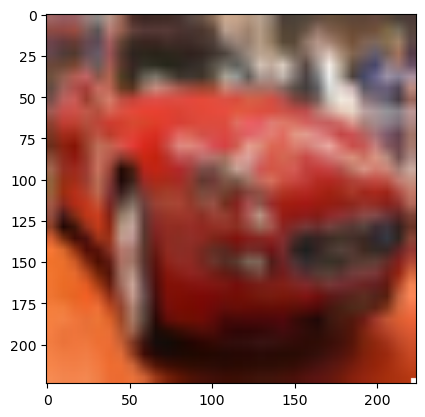

0

In [180]:
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

image, label = train_dataset[5]
image = unnormalize(image).clamp(0, 1)  # Clamp values to [0, 1] after unnormalizing
image = image.permute(1, 2, 0)
plt.imshow(image)  # Rearrange dimensions to (H, W, C) for display
plt.show()
label

In [6]:
class VGG16Modified(nn.Module):
    def __init__(self, num_classes=10, honeypot_location=5):
        super(VGG16Modified, self).__init__()
        
        # Load pretrained VGG-16 model and freeze parameters
        vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        for param in vgg16.parameters():
            param.requires_grad = False
            
        # Up to the first part
        self.features_part1 = nn.Sequential(*list(vgg16.features.children())[:honeypot_location])
        
        # Add a convolutional branch parallel to continue from the first pooling layer
        self.honey_pot = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10)
        )
        
        # Remaining VGG features (after the first part)
        self.features_part2 = nn.Sequential(*list(vgg16.features.children())[honeypot_location:])
        
        num_features = vgg16.classifier[6].in_features
        vgg16.classifier[6] = nn.Linear(num_features, 10)
        
        self.classifier = nn.Sequential(*list(vgg16.classifier.children()))

    def forward(self, x):
        x = self.features_part1(x)
        honey_pot = self.honey_pot(x)
        x = self.features_part2(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        main_prob = F.softmax(x, dim=1)
        honey_pot_prob = F.softmax(honey_pot, dim=1)
        return main_prob - honey_pot_prob

In [9]:
model = VGG16Modified(num_classes=10, honeypot_location=5)

In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Trainable")

Layer: honey_pot.2.weight | Trainable
Layer: honey_pot.2.bias | Trainable
Layer: classifier.6.weight | Trainable
Layer: classifier.6.bias | Trainable


In [172]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [169]:
def train(model, device, train_loader, criterion, optimizer, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            correct += outputs.argmax(axis=1).eq(labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {correct/len(train_loader.dataset):.4f}")

In [173]:
train(model, device, train_loader, criterion, optimizer, num_epochs)

KeyboardInterrupt: 

### Model Structure

In [7]:
import torch
import torchvision.models as models
from WeightedVGG16 import WeightedVGG16

def print_layer_shape(module, input, output):
    print(f"{module}: Output shape: {output.shape}")
    
input_data = torch.randn(1, 3, 224, 224)

# model = VGG16Modified(num_classes=10, honeypot_location=0)
# 
# # Register hook for each layer
# for layer in model.features_part1:
#     layer.register_forward_hook(print_layer_shape)
# for layer in model.features_part2:
#     layer.register_forward_hook(print_layer_shape)
# for layer in model.honey_pot:
#     layer.register_forward_hook(print_layer_shape)
# for layer in model.classifier:
#     layer.register_forward_hook(print_layer_shape)

model = WeightedVGG16(num_classes=10)
for layers in model.features:
    for layer in layers:
        layer.register_forward_hook(print_layer_shape)
for layers in model.classifiers:
    for layer in layers:
        layer.register_forward_hook(print_layer_shape)
for layer in model.last_classifier:
    layer.register_forward_hook(print_layer_shape)
model.weight_model.register_forward_hook(print_layer_shape)

    

# model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# 
#     
# input_data = torch.randn(1, 3, 224, 224)
# 
# for layer in model.features:
#     layer.register_forward_hook(print_layer_shape)
# for layer in model.classifier:
#     layer.register_forward_hook(print_layer_shape)

model(input_data)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([1, 64, 112, 112])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
ReLU(inplace=True): Output shape: torch.Size([1, 128, 112, 112])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
ReLU(inplace=True): Output shape: torch.Size([1, 128, 112, 112])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([1, 128, 56, 56])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pad

tensor([[-0.1454, -3.6775,  1.7581,  1.0387, -1.0307, -1.8987,  0.8591,  0.9758,
         -1.6754, -1.0705]], grad_fn=<AddmmBackward0>)

In [6]:
from WeightedVGG16 import WeightedVGG16

model = WeightedVGG16(num_classes=10)
model

WeightedVGG16(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [183]:
import csv
import matplotlib.pyplot as plt

def load_and_plot_losses(filename):
    losses = []
    # Read the CSV file
    with open(f"{filename}", "r") as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header
        for row in reader:
            losses.append(float(row[0]))

    # Plot the loaded losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Step Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Step Losses (Loaded from CSV)")
    plt.legend()
    plt.grid(True)
    plt.show()

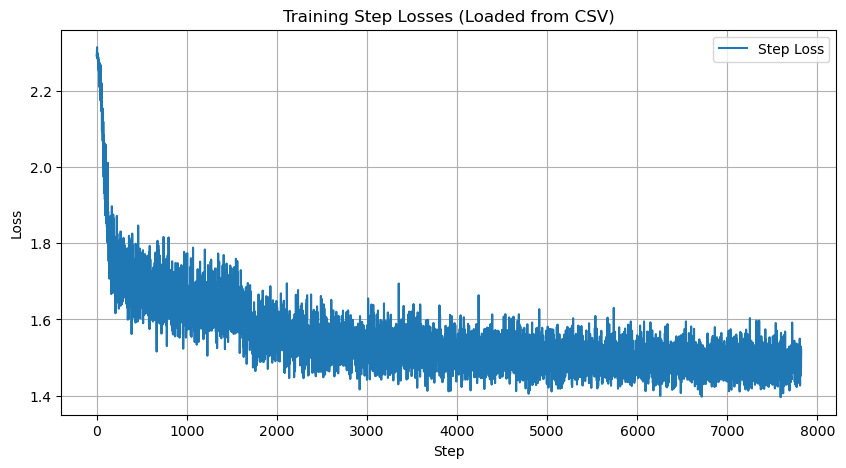

In [185]:
load_and_plot_losses("model_wo_freezestep_loss.csv")

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np

from typing import Union


class WeightedVGG16(nn.Module):
    def __init__(self, h_factor: int=7, num_classes=10):
        super(WeightedVGG16, self).__init__()

        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        num_features = vgg16.classifier[6].in_features
        vgg16.classifier[6] = nn.Linear(num_features, num_classes)

        self.features = []

        self.features.append(nn.Sequential(*list(vgg16.features.children())[0:5]))
        self.features.append(nn.Sequential(*list(vgg16.features.children())[5:10]))
        self.features.append(nn.Sequential(*list(vgg16.features.children())[10:17]))
        self.features.append(nn.Sequential(*list(vgg16.features.children())[17:24]))
        self.features.append(nn.Sequential(*list(vgg16.features.children())[24:]))

        self.classifiers = []

        for feature in self.features:
            channel = feature[-3].out_channels
            h = w = h_factor

            self.classifiers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d((h, w)),
                nn.Flatten(),
                nn.Linear(h * w * channel, num_classes),
            ))

        self.features = nn.ModuleList(self.features)

        self.classifiers = nn.ModuleList(self.classifiers)

        self.last_classifier = vgg16.classifier

        self.last_classifier.insert(0, nn.Flatten())

        self.weight_model = nn.Linear((len(self.classifiers) + 1) * num_classes, num_classes)

    def forward(self, x):
        fs = [x]
        clss = []
        for feature in self.features:
            fs.append(feature(fs[-1]))

        for i, classifier in enumerate(self.classifiers):
            clss.append(classifier(fs[i + 1]))

        clss.append(self.last_classifier(fs[-1]))
        clss = torch.cat(clss, dim=1)
        y = self.weight_model(clss)

        return y

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False

        for layer in self.classifiers:
            for param in layer.parameters():
                param.requires_grad = True
                
        for param in self.last_classifier.parameters():
            param.requires_grad = True

        for param in self.weight_model.parameters():
            param.requires_grad = True

        print("########## Model Freeze ##########")
        self.print_trainable_layers()

    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True

        print("######### Model Unfreeze #########")
        self.print_trainable_layers()

    def print_trainable_layers(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print(f"Layer: {name} | Trainable")
    
model = WeightedVGG16()
model.freeze()

########## Model Freeze ##########
Layer: classifiers.0.2.weight | Trainable
Layer: classifiers.0.2.bias | Trainable
Layer: classifiers.1.2.weight | Trainable
Layer: classifiers.1.2.bias | Trainable
Layer: classifiers.2.2.weight | Trainable
Layer: classifiers.2.2.bias | Trainable
Layer: classifiers.3.2.weight | Trainable
Layer: classifiers.3.2.bias | Trainable
Layer: classifiers.4.2.weight | Trainable
Layer: classifiers.4.2.bias | Trainable
Layer: last_classifier.1.weight | Trainable
Layer: last_classifier.1.bias | Trainable
Layer: last_classifier.4.weight | Trainable
Layer: last_classifier.4.bias | Trainable
Layer: last_classifier.7.weight | Trainable
Layer: last_classifier.7.bias | Trainable
Layer: weight_model.weight | Trainable
Layer: weight_model.bias | Trainable


In [24]:
model.weight_model

Linear(in_features=60, out_features=10, bias=True)

In [37]:
def print_layer_shape(module, input, output):
    print(f"{module}: Output shape: {output.shape}")

input_data = torch.randn(1, 3, 224, 224)

model = WeightedVGG16()

for feature in model.features:
    for layer in feature:
        layer.register_forward_hook(print_layer_shape)
for classifier in model.classifiers:
    for layer in classifier:
        layer.register_forward_hook(print_layer_shape)
model.weight_model.register_forward_hook(print_layer_shape)

model(input_data)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 64, 224, 224])
ReLU(inplace=True): Output shape: torch.Size([1, 64, 224, 224])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([1, 64, 112, 112])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
ReLU(inplace=True): Output shape: torch.Size([1, 128, 112, 112])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)): Output shape: torch.Size([1, 128, 112, 112])
ReLU(inplace=True): Output shape: torch.Size([1, 128, 112, 112])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([1, 128, 56, 56])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pad

tensor([[-1.5589,  0.0521, -1.1287, -0.1945,  1.2801,  2.3117,  0.9389,  1.1807,
          1.3789, -0.7359]], grad_fn=<AddmmBackward0>)

In [43]:
import pathlib

path = pathlib.Path(".").parent.absolute()
path / "test.txt"

SyntaxError: unexpected character after line continuation character (2426084946.py, line 4)

In [2]:
from helper import *

store_csv([1, 2, 3, 4], "test", "tt")

Saved to tt/test.csv


In [4]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--name', type=str, required=True, help="Model name")
parser.add_argument('--task', type=str, required=False, default="Honeypot", help="[Honeypot, Weighted, Honeypot_Native, Weighted_Native]")
parser.add_argument('--epochs', type=int, required=False, default=10, help="Epochs")
parser.add_argument('--batch_size', type=int, required=False, default=64, help="Batch size")
parser.add_argument('--honeypot_pos', type=int, required=False, default=0, help="Honeypot position")
parser.add_argument('--lamda', type=float, required=False, default=0.2, help="Lambda parameter")
parser.add_argument('--warmup_steps', type=int, required=False, default=1000, help="Warmup steps")
parser.add_argument('--seed', type=int, required=False, default=np.random.randint(2**30), help="Random seed")
parser.add_argument('--log_path', type=str, required=False, default="logs", help="Logs folder")
parser.add_argument('--ckpt_path', type=str, required=False, default="ckpts", help="Checkpoints folder")
parser.add_argument('--h_factor', type=int, required=False, default=7, help="h_factor")
parser.add_argument('--lr', type=float, required=False, default=1e-3, help="Learning rate")
parser.add_argument('--momentum', type=float, required=False, default=0.9, help="Momentum")
parser.add_argument('--num_classes', type=int, required=False, default=10, help="Number of classes")
parser.add_argument('--dataset', type=str, required=False, default="CIFAR10", help="Dataset name")

# parser.add_argument('--freeze', action='store_true', help="Freeze parameters")
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--name NAME] [--task TASK]
                             [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--honeypot_pos HONEYPOT_POS] [--lamda LAMDA]
                             [--warmup_steps WARMUP_STEPS] [--seed SEED]
                             [--log_path LOG_PATH] [--ckpt_path CKPT_PATH]
                             [--h_factor H_FACTOR] [--lr LR]
                             [--momentum MOMENTUM] [--num_classes NUM_CLASSES]
                             [--dataset DATASET]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/justin/Library/Jupyter/runtime/kernel-a445c755-cac5-41be-a3f6-34b6cfd70480.json


SystemExit: 2

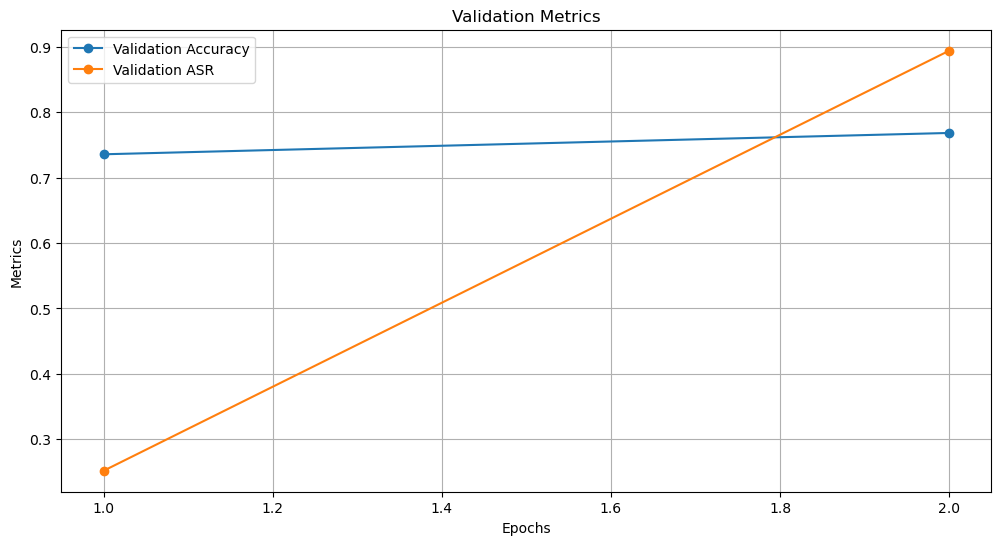

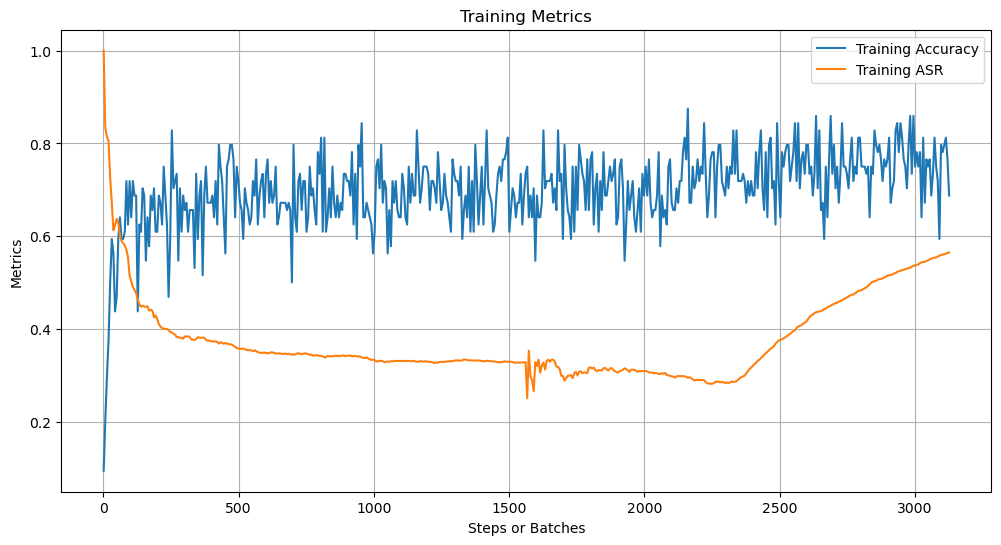

In [29]:
import re

# Log lines (replace this with reading from a file if needed)
with open('logs/one_run2.out', 'r') as f:
    log_lines = f.read().splitlines()

# Initialize placeholders
validation_metrics = []
training_metrics = []

# Regular expressions to match lines
validation_regex = r"Validation Accuracy: ([\d.]+), Validation ASR: ([\d.]+)"
training_regex = r"Loss=([\d.]+), Accuracy=([\d.]+), ASR=([\d.]+)"

# Set to track duplicate detection for validation metrics
validation_seen = set()
i = 0
# Process log lines
for line in log_lines:
    if line == '########### Parameters ###########':
        i += 1
        if i == k:
            break
        else:
            validation_metrics = []
            training_metrics = []
    # Match and store validation metrics
    validation_match = re.search(validation_regex, line)
    if validation_match:
        validation_data = validation_match.groups()
        if validation_data not in validation_seen:  # Skip duplicates
            validation_seen.add(validation_data)
            validation_metrics.append({
                "Validation Accuracy": float(validation_data[0]),
                "Validation ASR": float(validation_data[1])
            })
    
    # Match and store training metrics
    training_match = re.search(training_regex, line)
    if training_match:
        training_data = training_match.groups()
        training_metrics.append({
            "Loss": float(training_data[0]),
            "Accuracy": float(training_data[1]),
            "ASR": float(training_data[2])
        })
        
        
import matplotlib.pyplot as plt

validation_accuracy = [m["Validation Accuracy"] for m in validation_metrics]
validation_asr = [m["Validation ASR"] for m in validation_metrics]

training_loss = [m["Loss"] for m in training_metrics]
training_accuracy = [m["Accuracy"] for m in training_metrics]
training_asr = [m["ASR"] for m in training_metrics]

# Generate epochs for x-axis
epochs_validation = range(1, len(validation_metrics) + 1)
epochs_training = range(1, len(training_metrics) + 1)

# Plot validation metrics
plt.figure(figsize=(12, 6))
plt.plot(epochs_validation, validation_accuracy, label="Validation Accuracy", marker='o')
plt.plot(epochs_validation, validation_asr, label="Validation ASR", marker='o')
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid()
plt.show()

# Plot training metrics
plt.figure(figsize=(12, 6))
# plt.plot(epochs_training, training_loss, label="Training Loss", marker='o')
plt.plot(epochs_training[:4000:intv], training_accuracy[:4000:intv], label="Training Accuracy")
plt.plot(epochs_training[:4000:intv], training_asr[:4000:intv], label="Training ASR")
plt.title("Training Metrics")
plt.xlabel("Steps or Batches")
plt.ylabel("Metrics")
plt.legend()
plt.grid()
plt.show()

# # Print results
# print("Validation Metrics:")
# for metric in validation_metrics:
#     print(metric)
# 
# print("\nTraining Metrics:")
# for metric in training_metrics:
#     print(metric)


In [28]:
k = 2
intv = 6

In [24]:
validation_accuracy, validation_asr

([0.5077, 0.837, 0.807, 0.8152, 0.7653], [0.488, 0.156, 0.868, 0.842, 0.876])

In [26]:
training_accuracy[-4010:-4000], training_asr[-4010:-4000]

([0.7812, 0.7812, 0.75, 0.75, 0.8906, 0.8906, 0.7188, 0.7188, 0.7812, 0.7812],
 [0.8678,
  0.8678,
  0.8692,
  0.8692,
  0.8692,
  0.8692,
  0.8694,
  0.8694,
  0.8673,
  0.8673])

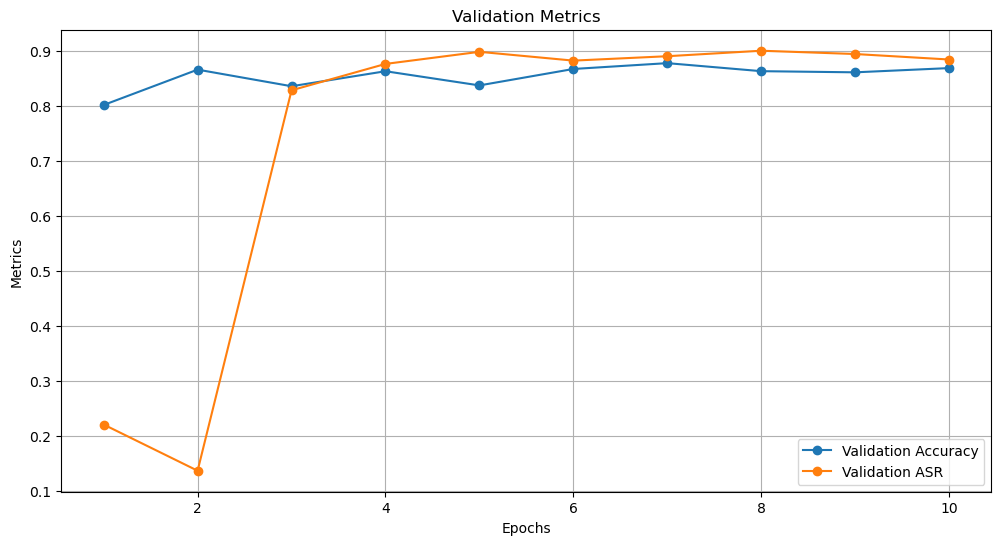

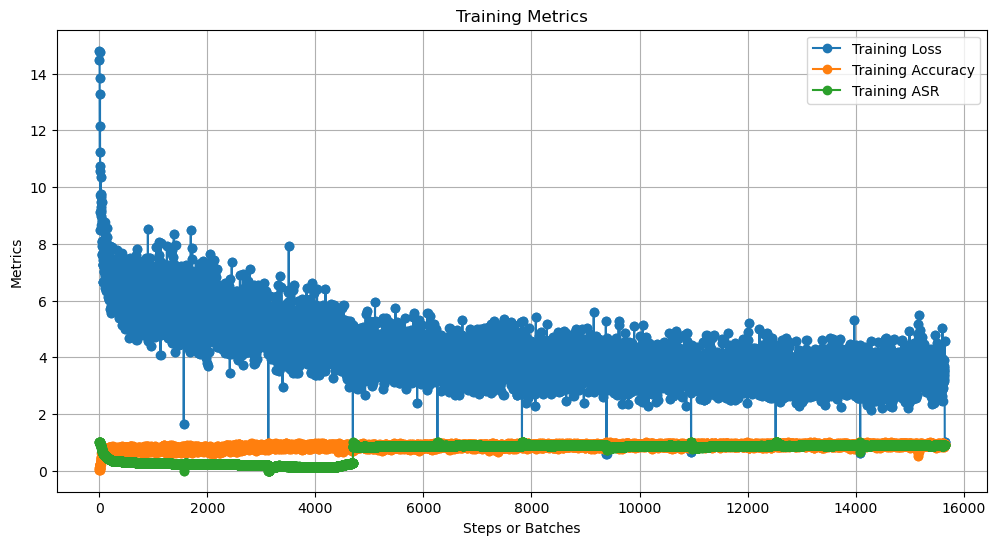

In [4]:
import matplotlib.pyplot as plt

validation_accuracy = [m["Validation Accuracy"] for m in validation_metrics]
validation_asr = [m["Validation ASR"] for m in validation_metrics]

training_loss = [m["Loss"] for m in training_metrics]
training_accuracy = [m["Accuracy"] for m in training_metrics]
training_asr = [m["ASR"] for m in training_metrics]

# Generate epochs for x-axis
epochs_validation = range(1, len(validation_metrics) + 1)
epochs_training = range(1, len(training_metrics) + 1)

# Plot validation metrics
plt.figure(figsize=(12, 6))
plt.plot(epochs_validation, validation_accuracy, label="Validation Accuracy", marker='o')
plt.plot(epochs_validation, validation_asr, label="Validation ASR", marker='o')
plt.title("Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid()
plt.show()

# Plot training metrics
plt.figure(figsize=(12, 6))
plt.plot(epochs_training, training_loss, label="Training Loss", marker='o')
plt.plot(epochs_training, training_accuracy, label="Training Accuracy", marker='o')
plt.plot(epochs_training, training_asr, label="Training ASR", marker='o')
plt.title("Training Metrics")
plt.xlabel("Steps or Batches")
plt.ylabel("Metrics")
plt.legend()
plt.grid()
plt.show()